In [1]:
import Bio.SeqIO
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date
from Bio.Align import PairwiseAligner
from Bio.Data import CodonTable
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif

In [2]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

protein = ESMProtein(sequence="MEKIVLLLATVSLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQDILEKTHNGKLCDLNGVKPLILRDCSVAGWLLGNPMCDEFINVPEWSYIVEKANPVNDLCYPGNFNDYEELKHLLSRINHLKKIKIIPKSYWSNHEASGVSSACSYLENPSFFRNVVWLTKNNTYPPIKVNYTNANQKDLLVLWIGIHHPNNEAEQTMLYQNPTTYISVGTSTLNQRLVPKIATRSKVNGQSGRVEFFWTILKSNDTINFESNGNFIAPENAYKIVKKGDSTIMKSELEYGNCNTKCQTPMGAINSSMPFHNIHPLTIGECPKYVKSNRLVLATGLRNTPQREGRRKKRGLFGAIAGFIEGGWQGMVDGWYGYHHSNEQGSGYAADKESTQKAIDGVTNKVNSIIDKMNTQFEAVGREFNNLERRIENLNKKMEDGFLDVWTYNAELLVLMENERTLDFHDSNVKNLYDKVRLQLRDNAKELGNGCFEFYHKCDNECMESVRNGTYDYPQYSEEARLKREEISGVKLESIGIYQILSIYSTVASSLVLAIIMAG")
client = ESMC.from_pretrained("esmc_600m").to("mps") # or "cpu"
protein_tensor = client.encode(protein)
logits_output = client.logits(
   protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
)
print(logits_output.logits, logits_output.embeddings)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/esm/pretrained.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


ForwardTrackData(sequence=tensor([[[-22.3554, -22.2066, -22.3444,  ..., -22.2894, -22.3648, -22.3717],
         [-25.1089, -24.9881, -25.1132,  ..., -25.0127, -25.0814, -25.1214],
         [-28.9792, -28.9319, -29.0462,  ..., -28.9774, -29.0099, -29.0181],
         ...,
         [-26.8784, -26.7908, -26.8981,  ..., -26.7895, -26.8899, -26.8672],
         [-25.5413, -25.4467, -25.5270,  ..., -25.4411, -25.5447, -25.5144],
         [-24.4490, -24.3322, -24.4222,  ..., -24.3285, -24.4401, -24.4212]]],
       device='mps:0'), structure=None, secondary_structure=None, sasa=None, function=None) tensor([[[ 0.0015, -0.0046, -0.0040,  ...,  0.0024,  0.0045,  0.0147],
         [ 0.0524, -0.0120, -0.0171,  ..., -0.0568, -0.0236, -0.0102],
         [ 0.0245, -0.0229, -0.0261,  ..., -0.0267,  0.0137, -0.0465],
         ...,
         [ 0.0285,  0.0194,  0.0069,  ..., -0.0194,  0.0058, -0.0046],
         [ 0.0199,  0.0274,  0.0012,  ..., -0.0284,  0.0008, -0.0132],
         [-0.0064,  0.0184, -0.0227

In [3]:
import os
import pandas as pd

# Path to your FASTA file
path = '/Users/ricardorivero/Documents/CPTS-570/Project/H5_GisaidData.clustered.aligned.fasta'

# Initialize an empty list to store sequences
sequences = []

# Open the FASTA file and read sequences
with open(path, 'r') as file:
    sequence = ''
    for line in file:
        line = line.strip()
        if line.startswith('>'):
            if sequence:
                sequences.append(sequence)
                sequence = ''
        else:
            sequence += line
    if sequence:
        sequences.append(sequence)

print(f"Total sequences loaded: {len(sequences)}")



Total sequences loaded: 591


In [4]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

# Load the model once outside the loop
model = ESMC.from_pretrained("esmc_300m").to("mps")  # or "cpu"

# Initialize a dictionary to store embeddings {index: embeddings_array}
embeddings = {}

# Loop over sequences and compute embeddings
for idx, seq in enumerate(sequences):
    # Create an ESMProtein object from the sequence
    protein = ESMProtein(sequence=seq)
    
    # Encode the protein into a tensor
    protein_tensor = model.encode(protein)
    
    # Get logits and embeddings
    # LogitsConfig with sequence=True and return_embeddings=True to get the embeddings per residue
    logits_output = model.logits(protein_tensor, LogitsConfig(sequence=True, return_embeddings=True))
    
    # Extract the embeddings tensor
    embds = logits_output.embeddings  # This should be a torch tensor
    
    # Move embeddings to CPU and convert to numpy
    embds_np = embds.cpu().detach().numpy()
    
    # Store in the dictionary
    embeddings[idx] = embds_np
    
    print(f"Got embeddings for sequence {idx} with shape: {embds_np.shape}")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/esm/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


Got embeddings for sequence 0 with shape: (1, 650, 960)
Got embeddings for sequence 1 with shape: (1, 650, 960)
Got embeddings for sequence 2 with shape: (1, 650, 960)
Got embeddings for sequence 3 with shape: (1, 650, 960)
Got embeddings for sequence 4 with shape: (1, 650, 960)
Got embeddings for sequence 5 with shape: (1, 650, 960)
Got embeddings for sequence 6 with shape: (1, 650, 960)
Got embeddings for sequence 7 with shape: (1, 650, 960)
Got embeddings for sequence 8 with shape: (1, 650, 960)
Got embeddings for sequence 9 with shape: (1, 650, 960)
Got embeddings for sequence 10 with shape: (1, 650, 960)
Got embeddings for sequence 11 with shape: (1, 650, 960)
Got embeddings for sequence 12 with shape: (1, 650, 960)
Got embeddings for sequence 13 with shape: (1, 650, 960)
Got embeddings for sequence 14 with shape: (1, 650, 960)
Got embeddings for sequence 15 with shape: (1, 650, 960)
Got embeddings for sequence 16 with shape: (1, 650, 960)
Got embeddings for sequence 17 with shape

In [5]:
embeddings

{0: array([[[ 0.0079909 , -0.00040225,  0.00455955, ...,  0.0066413 ,
           0.00107801, -0.00609631],
         [ 0.00074807,  0.03344835,  0.0457081 , ...,  0.04838055,
           0.02055718,  0.03625232],
         [ 0.01582978,  0.01226183,  0.00121076, ...,  0.01686839,
          -0.00807302,  0.02804469],
         ...,
         [-0.01552608,  0.00395391,  0.00761004, ...,  0.01169634,
          -0.00336214,  0.01467372],
         [-0.01514435,  0.01109932, -0.01737104, ...,  0.01966674,
          -0.02143736, -0.00853568],
         [ 0.0055273 ,  0.01399686,  0.00783168, ...,  0.01127642,
          -0.02756442, -0.02380017]]], dtype=float32),
 1: array([[[ 0.00853297, -0.00162553,  0.00296496, ...,  0.00562593,
           0.00066572, -0.00633972],
         [ 0.00556033,  0.02903842,  0.03912688, ...,  0.04620863,
           0.01436097,  0.03608433],
         [ 0.01893508,  0.01449195, -0.00472661, ...,  0.0145339 ,
          -0.01082877,  0.02776326],
         ...,
         [-0

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

###################################
# Assume you have the following:
# embeddings: dict {seq_id: embedding_array (seq_len, embedding_dim)}
# sequences: dict {seq_id: amino_acid_sequence_string}
# amino_acids: list of AA chars, e.g. ['A','R','N','D','C',...]
# aa_to_int: mapping from amino acid char to int index, 0 = unknown/pad
###################################

# 1. Determine max_seq_length from embeddings and pad embeddings
embedding_list = []
integer_sequences = []
sequence_ids = []
max_seq_length = max(emb.shape[0] for emb in embeddings.values())

# Prepare inputs (embedding_array) and targets (Y)
for seq_id, emb in embeddings.items():
    seq_length, embedding_dim = emb.shape
    pad_length = max_seq_length - seq_length
    if pad_length > 0:
        emb_padded = np.pad(emb, ((0, pad_length), (0, 0)), mode='constant', constant_values=0)
    else:
        emb_padded = emb
    embedding_list.append(emb_padded)
    sequence_ids.append(seq_id)
    
    # Encode amino acid sequence into integers and pad it
    seq_str = sequences[seq_id]
    int_seq = [aa_to_int.get(aa, 0) for aa in seq_str]
    if len(int_seq) < max_seq_length:
        int_seq = int_seq + [0]*(max_seq_length - len(int_seq))
    else:
        int_seq = int_seq[:max_seq_length]
    integer_sequences.append(int_seq)

embedding_array = np.stack(embedding_list)  # (num_sequences, max_seq_length, embedding_dim)
Y = np.array(integer_sequences)             # (num_sequences, max_seq_length)

# Split into train/test
sequence_indices = np.arange(embedding_array.shape[0])
train_indices, test_indices = train_test_split(
    sequence_indices, test_size=0.2, random_state=42, shuffle=True
)

embedding_array_train = embedding_array[train_indices]
embedding_array_test = embedding_array[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]

# Define model parameters
num_heads = 8
ff_dim = 256
dropout_rate = 0.1
num_layers = 2
l2_reg = 1e-5
num_classes = len(amino_acids) + 1  # +1 for padding/unknown
# embedding_dim known from above

# Input layer
inputs = Input(shape=(max_seq_length, embedding_dim))

# Masking layer
x = layers.Masking(mask_value=0.0)(inputs)

# Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(max_seq_len, embed_dim)
        self.supports_masking = True

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def positional_encoding(self, max_seq_len, embed_dim):
        angle_rads = self.get_angles(
            np.arange(max_seq_len)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs, mask=None):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def compute_mask(self, inputs, mask=None):
        return mask

# Add positional encoding
x = PositionalEncoding(max_seq_length, embedding_dim)(x)

# Transformer Encoder blocks
for _ in range(num_layers):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg),
    )(x, x, attention_mask=None)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(
        ff_dim,
        activation='relu',
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(out1)
    ffn_output = Dense(
        embedding_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Instead of predicting embeddings, we predict a probability distribution over amino acids
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model for classification
# Use sparse categorical crossentropy since Y is integer indices
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 64
batch_size = 32

dataset_train = tf.data.Dataset.from_tensor_slices((embedding_array_train, Y_train))
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

dataset_val = tf.data.Dataset.from_tensor_slices((embedding_array_test, Y_test))
dataset_val = dataset_val.batch(batch_size)

# Train
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
)

# Evaluate
test_loss, test_acc = model.evaluate(dataset_val)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}')

# Example of prediction
# Given an input embedding array (shape: (1, max_seq_length, embedding_dim))
# model.predict returns probabilities for each position and AA class
# Choose the most likely amino acids:
predicted_probs = model.predict(embedding_array_test[:1])  # Predict for first test seq
predicted_aa_indices = np.argmax(predicted_probs, axis=-1)[0]  # (max_seq_length,)
# Convert indices back to amino acids
predicted_sequence = ''.join(amino_acids[idx-1] if idx > 0 else '-' for idx in predicted_aa_indices)
print("Predicted sequence:", predicted_sequence)

ValueError: too many values to unpack (expected 2)

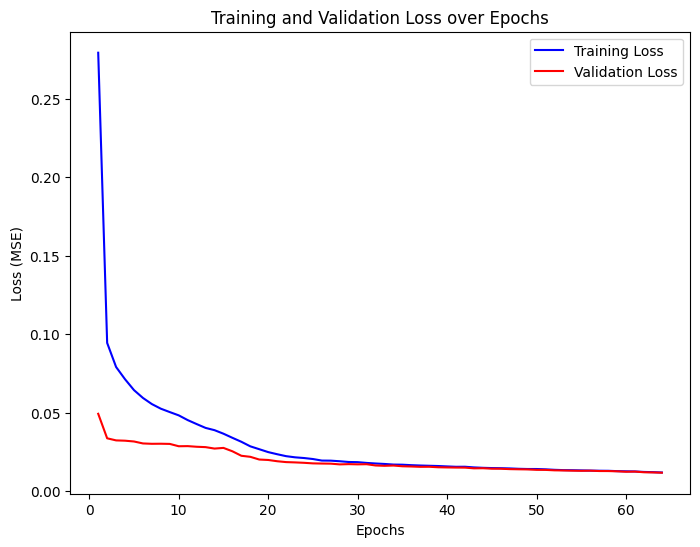

In [ ]:
import matplotlib.pyplot as plt

# Access loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

# Plot Loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, 'b-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [7]:
for seq_id, emb in embeddings.items():
    print(seq_id, emb.shape)

0 (1, 650, 960)
1 (1, 650, 960)
2 (1, 650, 960)
3 (1, 650, 960)
4 (1, 650, 960)
5 (1, 650, 960)
6 (1, 650, 960)
7 (1, 650, 960)
8 (1, 650, 960)
9 (1, 650, 960)
10 (1, 650, 960)
11 (1, 650, 960)
12 (1, 650, 960)
13 (1, 650, 960)
14 (1, 650, 960)
15 (1, 650, 960)
16 (1, 650, 960)
17 (1, 650, 960)
18 (1, 650, 960)
19 (1, 650, 960)
20 (1, 650, 960)
21 (1, 650, 960)
22 (1, 650, 960)
23 (1, 650, 960)
24 (1, 650, 960)
25 (1, 650, 960)
26 (1, 650, 960)
27 (1, 650, 960)
28 (1, 650, 960)
29 (1, 650, 960)
30 (1, 650, 960)
31 (1, 650, 960)
32 (1, 650, 960)
33 (1, 650, 960)
34 (1, 650, 960)
35 (1, 650, 960)
36 (1, 650, 960)
37 (1, 650, 960)
38 (1, 650, 960)
39 (1, 650, 960)
40 (1, 650, 960)
41 (1, 650, 960)
42 (1, 650, 960)
43 (1, 650, 960)
44 (1, 650, 960)
45 (1, 650, 960)
46 (1, 650, 960)
47 (1, 650, 960)
48 (1, 650, 960)
49 (1, 650, 960)
50 (1, 650, 960)
51 (1, 650, 960)
52 (1, 650, 960)
53 (1, 650, 960)
54 (1, 650, 960)
55 (1, 650, 960)
56 (1, 650, 960)
57 (1, 650, 960)
58 (1, 650, 960)
59 (1, 

In [8]:
# All in one cell

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

###################################
# Preprocessing Sequences and Embeddings
###################################

amino_acids = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
    'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'
]

aa_to_int = {aa: idx + 1 for idx, aa in enumerate(amino_acids)}  # Start indexing from 1
int_to_aa = {idx + 1: aa for idx, aa in enumerate(amino_acids)}

# Ensure that:
# embeddings: dict {seq_id: embedding_array} where embedding_array ~ (seq_len, embedding_dim) or (1, seq_len, embedding_dim)
# sequences: dict {seq_id: amino_acid_sequence_string}
# Both dictionaries have the same keys.

# Find max sequence length
max_seq_length = max(emb.shape[1] if (len(emb.shape) == 3 and emb.shape[0] == 1) else emb.shape[0] 
                     for emb in embeddings.values())

embedding_list = []
int_seq_list = []
sequence_ids = []
embedding_dim = None

for seq_id, emb in embeddings.items():
    # Adjust the shape if emb is (1, seq_len, emb_dim)
    if len(emb.shape) == 3 and emb.shape[0] == 1:
        emb = emb[0]
    elif len(emb.shape) != 2:
        raise ValueError(f"Embedding for {seq_id} has shape {emb.shape}, expected (seq_length, embedding_dim)")

    seq_length, emb_dim = emb.shape

    # Pad embeddings
    pad_length = max_seq_length - seq_length
    if pad_length > 0:
        emb_padded = np.pad(emb, ((0, pad_length), (0, 0)), mode='constant', constant_values=0)
    else:
        emb_padded = emb

    embedding_list.append(emb_padded)
    sequence_ids.append(seq_id)

    # Convert the corresponding sequence to integers and pad
    seq_str = sequences[seq_id]
    int_seq = [aa_to_int.get(aa, 0) for aa in seq_str]
    if len(int_seq) < max_seq_length:
        int_seq = int_seq + [0]*(max_seq_length - len(int_seq))
    else:
        int_seq = int_seq[:max_seq_length]

    # Append to int_seq_list
    int_seq_list.append(int_seq)

embedding_array = np.stack(embedding_list)  # (num_sequences, max_seq_length, embedding_dim)
Y = np.array(int_seq_list)                  # (num_sequences, max_seq_length)

num_classes = len(amino_acids) + 1  # +1 for padding/unknown
Y_one_hot = tf.keras.utils.to_categorical(Y, num_classes=num_classes)  # (num_sequences, max_seq_length, num_classes)

sequence_indices = np.arange(embedding_array.shape[0])
train_indices, test_indices = train_test_split(sequence_indices, test_size=0.1, random_state=42, shuffle=True)

X_train = embedding_array[train_indices]
X_val = embedding_array[test_indices]
Y_train = Y_one_hot[train_indices]
Y_val = Y_one_hot[test_indices]

###################################
# Transformer Model Definition
###################################

class PositionalEncoding(Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(max_seq_len, embed_dim)
        self.supports_masking = True

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def positional_encoding(self, max_seq_len, embed_dim):
        angle_rads = self.get_angles(
            np.arange(max_seq_len)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs, mask=None):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def compute_mask(self, inputs, mask=None):
        return mask

num_heads = 8
ff_dim = 256
dropout_rate = 0.1
num_layers = 2
l2_reg = 1e-5

inputs = Input(shape=(max_seq_length, emb_dim))
x = layers.Masking(mask_value=0.0)(inputs)
x = PositionalEncoding(max_seq_length, emb_dim)(x)

for _ in range(num_layers):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=emb_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg),
    )(x, x, attention_mask=None)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(
        ff_dim,
        activation='relu',
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(out1)
    ffn_output = Dense(
        emb_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

epochs = 10
batch_size = 32

dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(buffer_size=1024).batch(batch_size)
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val)

# Evaluate
test_loss, test_accuracy = model.evaluate(dataset_val)
print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}")

# Predict on the first validation sample
pred_probs = model.predict(X_val[:1])
pred_indices = np.argmax(pred_probs, axis=-1)[0]  # (max_seq_length,)
pred_sequence = ''.join(int_to_aa.get(idx, '-') for idx in pred_indices)
print("Predicted sequence:", pred_sequence)

2024-12-11 20:58:20.595999: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-11 20:58:20.596051: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-11 20:58:20.596054: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-11 20:58:20.596070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 20:58:20.596082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 650, 960)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 650, 960)  │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 650, 960)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 650)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 650, 960)  │          0 │ masking[0][0],    │
│ (PositionalEncodin… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 650, 960)  │ 29,515,200 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
│                     │                   │            │ any[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 650, 960)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 650, 960)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 650, 960)  │      1,920 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 650, 256)  │    246,016 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 650, 960)  │    246,720 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 650, 960)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 650, 960)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 650, 960)  │      1,920 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 650, 960)  │ 29,515,200 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 650, 960)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 650, 960)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 650, 960)  │      1,920 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 60,043,733 (229.05 MB)

 Trainable params: 60,043,733 (229.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.0638 - loss: 0.1170 - val_accuracy: 0.0437 - val_loss: 0.1256
Epoch 2/10
13/17 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0452 - loss: 0.1245

KeyboardInterrupt: 